Notebook purpose

- Develop analysis code

In [1]:
import contextlib
import math
import os
import re
import sys

import linearmodels as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.analysis.helpers as ah
import entropy.analysis.make_analysis_data as ad
import entropy.analysis.sumstats_table as ss
import entropy.data.cleaners as cl
import entropy.data.selectors as sl
import entropy.figures.figures as ff
import entropy.figures.helpers as fh
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

SAMPLE = "XX7"

In [2]:
import warnings

warnings.filterwarnings("once")

## Data description

**Read transactions data**

In [3]:
# dft = hd.read_txn_data("777")
# hd.inspect(dft)

**Read analysis data**

In [4]:
df = hd.read_analysis_data(SAMPLE)
hd.inspect(df)

Time for read_analysis_data            : 2.40 seconds
(84,096, 28)


active_accounts  txns_count   txns_value  \
user_id date                                                                    
37      2012-02-29  [287407, 287405, 287406, 287404]          22  9495.810547   
        2012-03-31  [287405, 287407, 287406, 287404]          16  2147.699951   

                    txn_count_sa  txn_count_ca  monthly_spend  \
user_id date                                                    
37      2012-02-29           3.0           8.0     528.239990   
        2012-03-31           2.0           9.0     429.880005   

                    log_monthly_spend  prop_spend_services  \
user_id date                                                 
37      2012-02-29           6.269551             0.224898   
        2012-03-31           6.063506             0.028799   

                    prop_spend_other_spend  prop_spend_household  \
user_id date                                                       
37      2012-02-29                0.088596              0.591852   
        2012-03-31                0.093049              0.761841   

                    prop_spend_travel  prop_spend_communication  \
user_id date                                                      
37      2012-02-29                0.0                  0.094654   
        2012-03-31                0.0                  0.116312   

                    prop_spend_finance  prop_spend_motor  prop_spend_retail  \
user_id date                                                                  
37      2012-02-29                 0.0               0.0                0.0   
        2012-03-31                 0.0               0.0                0.0   

                    prop_spend_hobbies  monthly_income  annual_income  \
user_id date                                                            
37      2012-02-29                 0.0     1687.530029   18768.632812   
        2012-03-31                 0.0     1085.790039   18768.632812   

                    entropy_sptac    region   age  female  sa_inflows  \
user_id date                                                            
37      2012-02-29       2.899397  Scotland  27.0     0.0      3340.0   
        2012-03-31       3.039149  Scotland  27.0     0.0         0.0   

                    sa_outflows  sa_net_inflows  sa_scaled_inflows  \
user_id date                                                         
37      2012-02-29       1740.0          1600.0           2.135478   
        2012-03-31          0.0             0.0           0.000000   

                    sa_scaled_outflows  sa_scaled_net_inflows  
user_id date                                                   
37      2012-02-29            1.112494               1.022983  
        2012-03-31            0.000000               0.000000

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x1637b3700>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


**Sample selection - see paper**

**Number of unique users**

In [5]:
df.index.get_level_values("user_id").nunique()

2777

**Number of months we observe users for**

count    2777.000000
mean       30.283039
std        17.556614
min         6.000000
25%        16.000000
50%        26.000000
75%        41.000000
max       102.000000
dtype: float64


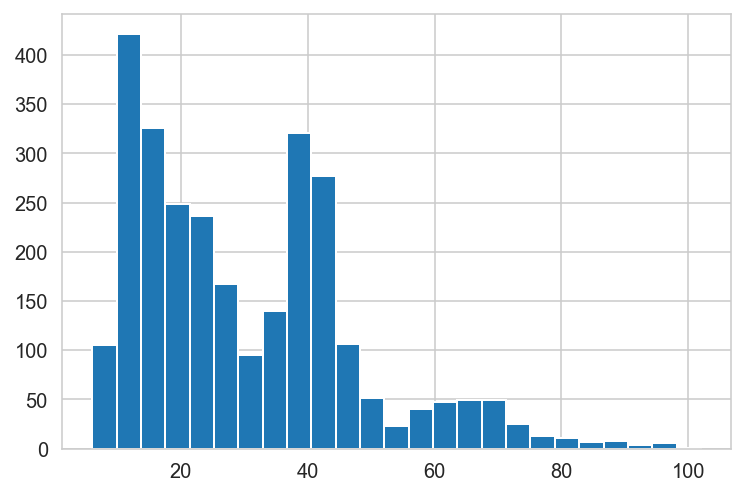

In [10]:
user_months = df.groupby("user_id").size()
print(user_months.describe())
user_months.hist(bins=25);

**User characteristics**

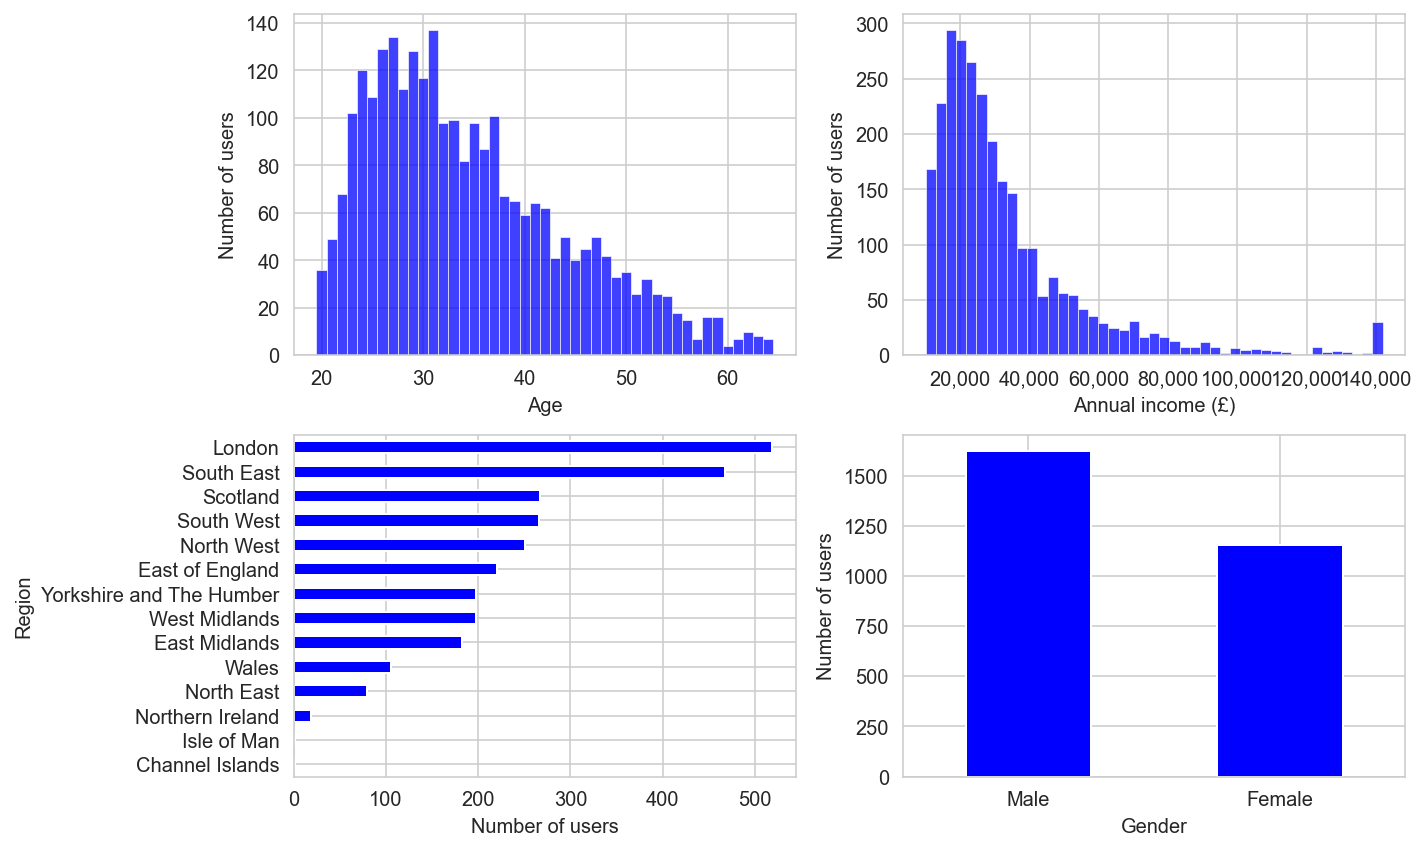

In [11]:
ff.user_chars(df, write=False)

**Summary statistics**

In [12]:
ss.main(df, write=False)

,count,mean,std,min,max,25%,50%,75%
txns_count,84096.0,111.432922,62.344943,6.000000,9.700000e+02,70.000000,99.000000,138.000000
txns_value,84096.0,20576.199219,103511.054688,254.350006,2.139299e+07,5994.772339,10201.174805,18908.122559
txn_count_sa,84096.0,4.289051,8.646355,0.000000,3.890000e+02,0.000000,2.000000,5.000000
txn_count_ca,84096.0,91.553784,53.784811,5.000000,9.060000e+02,55.000000,81.000000,116.000000
monthly_spend,84096.0,2917.458008,5339.084961,200.770004,4.356753e+05,1221.357483,1954.375000,3256.315002
log_monthly_spend,84096.0,7.617547,0.767820,5.302160,1.298465e+01,7.107718,7.577826,8.088352
prop_spend_services,84096.0,0.191606,0.142546,0.000000,1.000000e+00,0.089566,0.157261,0.256794
prop_spend_other_spend,84096.0,0.124968,0.138620,0.000000,1.000000e+00,0.029467,0.079698,0.171050
prop_spend_household,84096.0,0.363573,0.203999,0.000000,1.000000e+00,0.204765,0.345460,0.505578
prop_spend_travel,84096.0,0.051400,0.097043,0.000000,9.785931e-01,0.000000,0.012227,0.056753


## Dependent variable - savings account inflows

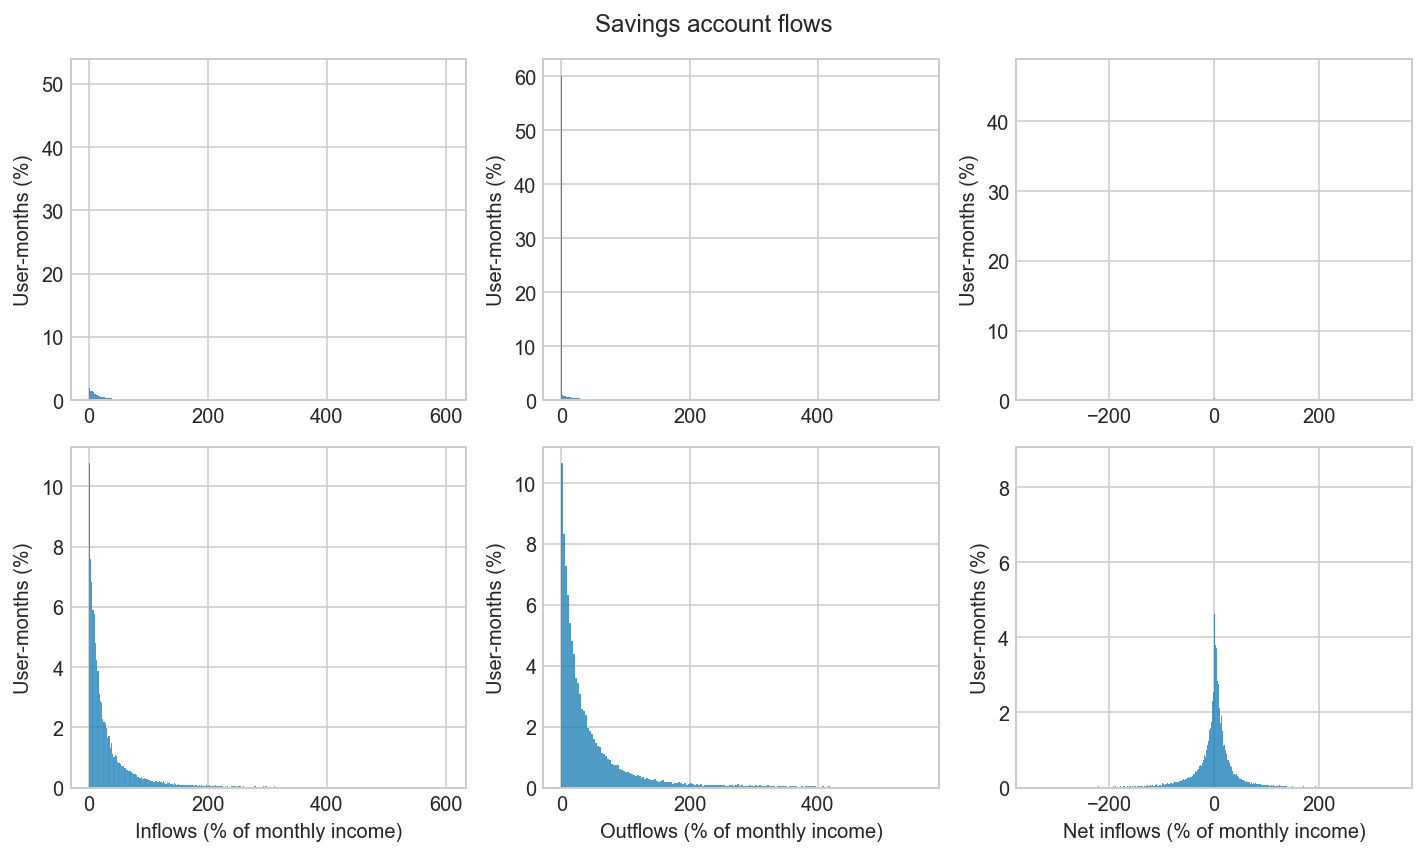

In [13]:
ff.sa_flows(df, write=False);

## Independent variable - entropy

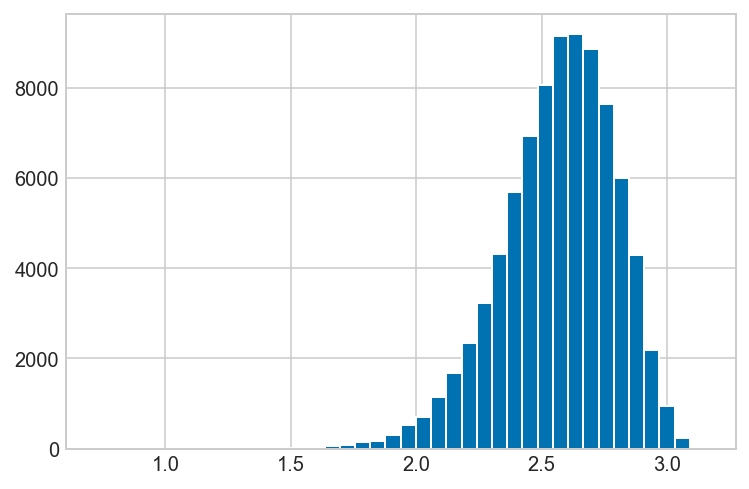

In [14]:
df.entropy_sptac.hist(bins=40);

Entropy calculation details

In [160]:
def user_month_entropy(df):
    def _calc_entropy(probs):
        return -sum(p * math.log2(p) for p in probs)

    return df.apply(_calc_entropy, axis=1)


# cr.entropy_spend_tag_counts_partial(dft)

## Correlations

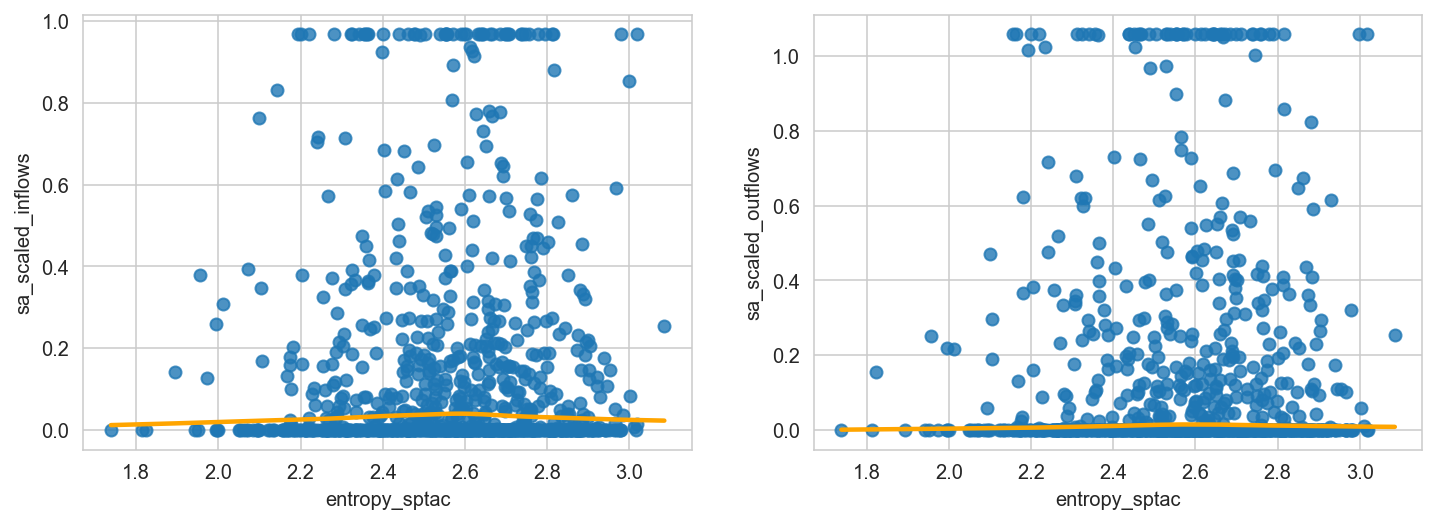

In [34]:
ff.regplot(df, y="sa_scaled_[io]", x="entropy", winsorise_kws=dict(pct=5, how="upper"))

## Main results

### Binary outcomes

In [15]:
data = df

y = data["has_sa_inflows"]
prop_spends = list(data.filter(like="prop_spend").columns)
controls = ["log_monthly_spend"] + prop_spends
exog = data[["entropy_sptac"] + controls]

lm.panel.compare(
    [
        ah.fe_reg(y, exog, entity_effects=True, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=True, time_effects=False),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=False),
    ],
    stars=True,
)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3
Dep. Variable,has_sa_inflows,has_sa_inflows,has_sa_inflows,has_sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,84096,84096,84096,84096
Cov. Est.,Clustered,Clustered,Clustered,Clustered
R-squared,0.0048,0.0093,0.0017,0.5216
R-Squared (Within),0.0085,0.0093,0.0013,0.0037
R-Squared (Between),-1.11e+09,-9.215e+08,-4.151e+09,0.7180
R-Squared (Overall),-8.745e+08,-7.263e+08,-3.272e+09,0.5216
F-statistic,35.795,69.387,13.289,8333.3
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


### Brown bag and post brown bag - inflows including outliers

In [3]:
data = df

y = data["sa_scaled_inflows"]
prop_spends = list(data.filter(like="prop_spend").columns)
controls = ["log_monthly_spend"] + prop_spends
exog = data[["entropy_sptac"] + controls]

lm.panel.compare(
    [
        ah.fe_reg(y, exog, entity_effects=True, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=True, time_effects=False),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=False),
    ],
    stars=True,
)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,93557,93557,93557,93557
Cov. Est.,Clustered,Clustered,Clustered,Clustered
R-squared,0.0016,0.0017,0.0035,0.0113
R-Squared (Within),0.0016,0.0017,0.0014,0.0014
R-Squared (Between),-1.597e+07,-2.081e+06,-1.573e+09,0.1095
R-Squared (Overall),-1.654e+06,-2.155e+05,-1.629e+08,0.0113
F-statistic,12.971,13.615,29.520,97.513
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


### Removing outliers

In [6]:
trim_pcts = [0, 1, 5, 10]

for trim_pct in trim_pcts:
    dd = df.copy()
    dd["sa_scaled_inflows"] = hd.trim(df.sa_scaled_inflows, pct=trim_pct, how="upper")

    data = dd
    y = data["sa_scaled_inflows"]
    prop_spends = list(data.filter(like="prop_spend").columns)
    controls = ["log_monthly_spend"] + prop_spends
    exog = data[["entropy_sptac"] + controls]

    print(f"Trim pct: {trim_pct}")
    print(
        lm.panel.compare(
            [
                ah.fe_reg(y, exog, entity_effects=True, time_effects=True),
                ah.fe_reg(y, exog, entity_effects=True, time_effects=False),
                ah.fe_reg(y, exog, entity_effects=False, time_effects=True),
                ah.fe_reg(y, exog, entity_effects=False, time_effects=False),
            ],
            stars=True,
        )
    )

Trim pct: 0
                                                  Model Comparison                                                  
                                           Model 0               Model 1               Model 2               Model 3
--------------------------------------------------------------------------------------------------------------------
Dep. Variable                    sa_scaled_inflows     sa_scaled_inflows     sa_scaled_inflows     sa_scaled_inflows
Estimator                                 PanelOLS              PanelOLS              PanelOLS              PanelOLS
No. Observations                             93556                 93556                 93556                 93556
Cov. Est.                                Clustered             Clustered             Clustered             Clustered
R-squared                                   0.0019                0.0020                0.0041                0.0138
R-Squared (Within)                          0.0020  

### Possible explanations and next steps

- Check data integrity

- Entropy measure doesn't capture behaviour we want 

    - Calculate alternative entropy measures
    
    - Validate entropy measures by correlating them with other indicators of stress


- Model is misspecified

    - Take into account truncated distribution of outcome variable using Tobit model

## Further analysis

### Unscaled income flows

In [140]:
data = df

y = data["sa_inflows"]
prop_spend = list(data.filter(like="prop_spend").columns)
controls = ["log_monthly_spend", "log_income"] + prop_spend
exogenous = data[["entropy_sptac"] + controls]

lm.panel.compare(
    [
        ah.fe_reg(y, exogenous, entity_effects=True, time_effects=True),
        ah.fe_reg(y, exogenous, entity_effects=True, time_effects=False),
        ah.fe_reg(y, exogenous, entity_effects=False, time_effects=True),
        ah.fe_reg(y, exogenous, entity_effects=False, time_effects=False),
    ],
    stars=True,
)

,Model 0,Model 1,Model 2,Model 3
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,93557,93557,93557,93557
Cov. Est.,Clustered,Clustered,Clustered,Clustered
R-squared,0.0007,0.0007,0.0049,0.0076
R-Squared (Within),0.0007,0.0007,0.0003,0.0003
R-Squared (Between),-7.025e+06,-2.185e+06,-7.158e+09,0.0624
R-Squared (Overall),-1.41e+06,-4.388e+05,-1.437e+09,0.0076
F-statistic,5.2157,5.5482,38.613,59.400
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


### Individual controls

In [75]:
b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,9.548e-06,0.0005,0.0018,0.0002,0.0018,0.0018,0.0019,0.0040,0.0122
R-Squared (Within),9.284e-06,0.0005,0.0018,0.0003,0.0019,0.0019,0.0019,0.0017,0.0015
R-Squared (Between),-0.1107,-13.844,-3.5250,0.0934,-4.7574,-4.7574,-4.7990,-4.9851,0.1175
R-Squared (Overall),-0.0108,-1.3933,-0.3635,0.0090,-0.4885,-0.4885,-0.4926,-0.5107,0.0122
F-statistic,0.9901,28.384,92.464,2.8433,19.196,19.196,19.846,42.757,132.48
P-value (F-stat),0.3197,0.0000,0.0000,0.0024,0.0000,0.0000,0.0000,0.0000,0.0000


#### Pooled

In [71]:
full_controls = ["log_income", "age", "female", "log_monthly_spend"] + tag_spend

a = lm.PanelOLS(y, sm.add_constant(data["entropy_sptac"])).fit()
aa = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_income"]])).fit()
ab = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "age"]])).fit()
ac = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "female"]])).fit()
ad = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_monthly_spend"]])).fit()
ae = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + tag_spend[:-1]])).fit()
af = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit()
ag = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit(
    cov_type="clustered", cluster_entity=True
)


lm.panel.compare([a, aa, ab, ac, ad, ae, af, ag], stars=True)

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,2.985e-05,9.394e-05,0.0014,0.0002,0.0037,0.0011,0.0069,0.0069
R-Squared (Within),-4.12e-05,9.208e-05,-3.02e-05,-5.145e-05,0.0018,1.925e-05,0.0025,0.0025
R-Squared (Between),0.0006,0.0005,0.0193,0.0025,0.0252,0.0124,0.0618,0.0618
R-Squared (Overall),2.985e-05,9.394e-05,0.0014,0.0002,0.0037,0.0011,0.0069,0.0069
F-statistic,3.2024,5.0403,77.068,8.4124,197.00,12.888,52.893,52.893
P-value (F-stat),0.0735,0.0065,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000


### Total inflows

In [72]:
data = df
y = data["sa_inflows"]
tag_spend = list(df.filter(like="tag_spend").columns)
full_controls = ["log_income", "log_monthly_spend"] + tag_spend[:-1]

### Fixed effects

In [73]:
b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,2.97e-06,3.711e-05,0.0009,8.9e-05,0.0009,0.0009,0.0009,0.0053,0.0075
R-Squared (Within),3.935e-06,4.764e-05,0.0009,9.283e-05,0.0009,0.0009,0.0009,0.0006,0.0002
R-Squared (Between),-0.0186,-0.1242,-0.8894,-0.0112,-1.2358,-1.2358,-1.2670,-7.5494,0.0558
R-Squared (Overall),-0.0035,-0.0277,-0.1835,-0.0021,-0.2537,-0.2537,-0.2600,-1.5241,0.0075
F-statistic,0.3080,1.9241,44.459,1.0255,8.5301,8.5301,8.9177,51.709,73.813
P-value (F-stat),0.5789,0.1460,0.0000,0.4164,0.0000,0.0000,0.0000,0.0000,0.0000


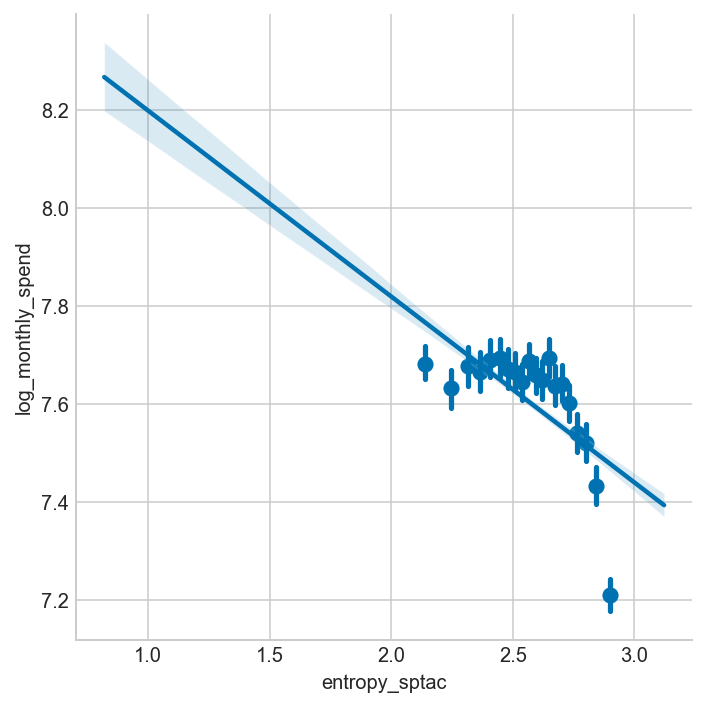

In [96]:
sns.lmplot(
    data=df.sample(frac=0.3), x="entropy_sptac", y="log_monthly_spend", x_bins=20
)